In [191]:
import numpy as np
import glob
import pandas as pd
import ast
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense


In [4]:
datapath = "../keypoints/"

In [5]:
kp_files = glob.glob(datapath + '*.txt')

In [11]:
# Get labels from file names
labels = [int(x.split('_')[0].split("/")[-1]) for x in kp_files]

In [85]:
# read in text files
len(labels)

19

In [121]:
[data.kpoints[0][j][1] for j in kp_ind]

[0.3318314850330353,
 0.30076107382774353,
 0.28024882078170776,
 0.41986939311027527,
 0.37887880206108093,
 0.6999762654304504,
 0.7189609408378601,
 0.7985836863517761,
 0.7080302834510803]

In [228]:
data = pd.read_csv(kp_files[0], sep="\t", header=None)
data.columns = ["time", "kpoints", "count", "fps"]
data.kpoints = data.kpoints.apply(lambda x: ast.literal_eval(x.strip("()")))

sel_kp = []

for i in range(data.shape[0]):
    kp_y = [data.kpoints[0][j][1] for j in kp_ind]
    t = [data.time[i]]
    sel_kp.append(t+kp_x+kp_y)

feat = np.array(sel_kp)

In [232]:
sel_kp[0:2]

2

In [128]:
# Focus on upper body keypoints
kp_ind = [0, 1, 2, 3, 4, 5, 6, 7, 17]

features = []

for file in kp_files:
    data = pd.read_csv(file, sep="\t", header=None)
    data.columns = ["time", "kpoints", "count", "fps"]
    data.kpoints = data.kpoints.apply(lambda x: ast.literal_eval(x.strip("()")))
    
    sel_kp = []

    for i in range(data.shape[0]):
        kp_x = [data.kpoints[0][j][1] for j in kp_ind]
        kp_y = [data.kpoints[0][j][1] for j in kp_ind]
        t = [data.time[i]]
        sel_kp.append(list(t+kp_x+kp_y))
        
    feat = np.array(sel_kp)
    
    features.append(feat)

In [205]:
data.

,time,kpoints,count,fps
0,1.605553e+09,"[(0, 0.529125452041626, 0.3717993199825287), (...",1,53.949502
1,1.605553e+09,"[(0, 0.5283065438270569, 0.37145838141441345),...",2,50.406855
2,1.605553e+09,"[(0, None, None), (1, None, None), (2, None, N...",3,51.169393
3,1.605553e+09,"[(0, 0.5283210277557373, 0.3713357150554657), ...",4,44.569522
4,1.605553e+09,"[(0, 0.5286968946456909, 0.37130624055862427),...",5,51.506828


In [237]:
#TESTING
kp_ind = [0, 1, 2, 3, 4, 5, 6, 7, 17]

features = []

for file in kp_files:
    data = pd.read_csv(file, sep="\t", header=None)
    data.columns = ["time", "kpoints", "count", "fps"]
    data.kpoints = data.kpoints.apply(lambda x: ast.literal_eval(x.strip("()")))
    times = [t-data.time[0] for t in data.time]
    
    sel_kp = []

    for i in range(data.shape[0]):
#         kp_x = [data.kpoints[0][j][1:3] for j in kp_ind]
        kp_y = [data.kpoints[0][j][1] for j in kp_ind]
        t = [times[i]]
        ob_feat = t + kp_y
        sel_kp.append(ob_feat)
        
    feat = np.array(sel_kp)
    
    features.append(sel_kp)

In [245]:
with open('features.txt', 'w') as filehandle:
    for listitem in features:
        filehandle.write('%s\n' % listitem)

In [246]:
with open('labels.txt', 'w') as filehandle:
    for listitem in labels:
        filehandle.write('%s\n' % listitem)

In [242]:
X = np.array(features)
print(X.shape)

(19, 450, 10)


In [224]:
Y = np.array(labels)
print(Y.shape)

(19,)


In [132]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=24601)

In [188]:
450*19

8550

In [200]:
model = tf.keras.Sequential([
    Convolution2D(filters=32, kernel_size = (3,3), input_shape=((450,19),), activation="relu"),
    MaxPooling2D(pool_size=(2,2))
#     Flatten(),
#     Dense(450, activation='relu'),
#     Dense(1)
])

# n_features = (450, 19)

# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
# model.add(tf.keras.layers.Dense(8, activation='relu', kernel_initializer='he_normal'))
# model.add(tf.keras.layers.Dense(1))

# model = tf.keras.Sequential([
#     tf.keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=((450, 19),)),
#     tf.keras.layers.Dense(8, activation='relu', kernel_initializer='he_normal'),
#     tf.keras.layers.Dense(1)
# ])


TypeError: Error converting shape to a TensorShape: int() argument must be a string, a bytes-like object or a number, not 'tuple'.

In [186]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(0.001), metrics=["mse", "mae"])

In [187]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 8550)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                547264    
_________________________________________________________________
dense_17 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 65        
Total params: 551,489
Trainable params: 551,489
Non-trainable params: 0
_________________________________________________________________


In [173]:
history = model.fit(X_train, Y_train, epochs=100)

Train on 16 samples
Epoch 1/100
16/16 [==============================] - 0s 19ms/sample - loss: 647.5000 - mean_squared_error: 647.5000 - mean_absolute_error: 23.5000
Epoch 2/100
16/16 [==============================] - 0s 1ms/sample - loss: 647.4530 - mean_squared_error: 647.4530 - mean_absolute_error: 23.4990
Epoch 3/100
16/16 [==============================] - 0s 2ms/sample - loss: 647.4060 - mean_squared_error: 647.4060 - mean_absolute_error: 23.4980
Epoch 4/100
16/16 [==============================] - 0s 2ms/sample - loss: 647.3590 - mean_squared_error: 647.3590 - mean_absolute_error: 23.4970
Epoch 5/100
16/16 [==============================] - 0s 3ms/sample - loss: 647.3120 - mean_squared_error: 647.3120 - mean_absolute_error: 23.4960
Epoch 6/100
16/16 [==============================] - 0s 2ms/sample - loss: 647.2650 - mean_squared_error: 647.2650 - mean_absolute_error: 23.4950
Epoch 7/100
16/16 [==============================] - 0s 2ms/sample - loss: 647.2180 - mean_squared_erro

Epoch 57/100
16/16 [==============================] - 0s 2ms/sample - loss: 644.8719 - mean_squared_error: 644.8719 - mean_absolute_error: 23.4440
Epoch 58/100
16/16 [==============================] - 0s 2ms/sample - loss: 644.8251 - mean_squared_error: 644.8251 - mean_absolute_error: 23.4430
Epoch 59/100
16/16 [==============================] - 0s 3ms/sample - loss: 644.7783 - mean_squared_error: 644.7783 - mean_absolute_error: 23.4420
Epoch 60/100
16/16 [==============================] - 0s 2ms/sample - loss: 644.7314 - mean_squared_error: 644.7314 - mean_absolute_error: 23.4410
Epoch 61/100
16/16 [==============================] - 0s 2ms/sample - loss: 644.6846 - mean_squared_error: 644.6846 - mean_absolute_error: 23.4400
Epoch 62/100
16/16 [==============================] - 0s 2ms/sample - loss: 644.6377 - mean_squared_error: 644.6377 - mean_absolute_error: 23.4390
Epoch 63/100
16/16 [==============================] - 0s 2ms/sample - loss: 644.5909 - mean_squared_error: 644.5909 - 

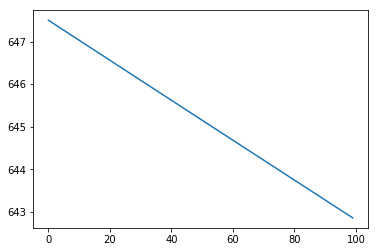

In [174]:
plt.plot(history.history['mean_squared_error'])

In [149]:
model.evaluate(X_test, Y_test)

3/3 [==============================] - 0s 61ms/sample - loss: 16.5233 - mean_squared_error: 279.2430 - mean_absolute_error: 16.5233


[16.523340225219727, 279.243, 16.52334]

In [175]:
model.predict(X_test)

array([[0.09992807],
       [0.09992807],
       [0.09992807]], dtype=float32)

In [152]:
Y_test

array([14, 20, 18])

In [167]:
test_pred

array([[0.9099187],
       [0.9099187],
       [0.9099187]], dtype=float32)

## Example plots

In [21]:
r_ear = []

for i in range(len(data.kpoints)):
    r_ear.append(data.kpoints[i][4][2])

Text(0.5,1,'R ear')

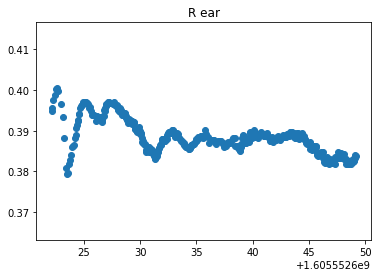

In [24]:
plt.scatter(data.time.values, r_ear)
plt.title("R ear")

Text(0.5,1,'R shoulder')

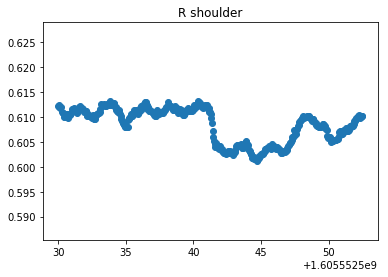

In [58]:
data = pd.read_csv(kp_files[4], sep="\t", header=None)
data.columns = ["time", "kpoints", "count", "fps"]
data.kpoints = data.kpoints.apply(lambda x: ast.literal_eval(x.strip("()")))

r_shoulder = []

for i in range(len(data.kpoints)):
    r_shoulder.append(data.kpoints[i][3][2])
    
plt.scatter(data.time.values, r_shoulder)
plt.title("R shoulder")